# Fully Conencted Neural Network
This section models a Simple fully connected neural network

## Downloading and extracting the CIFAR10 dataset

In [ ]:
!gdown --id 1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g -O CIFAR10.tar.gz

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g
To: /content/CIFAR10.tar.gz
100% 19.8M/19.8M [00:00<00:00, 61.5MB/s]


In [ ]:
!tar xzf CIFAR10.tar.gz

# Programming the model

## Initial setup
Configuring the network hyperparameters

In [ ]:
import matplotlib.pyplot as pyplot
import matplotlib.image as mplimage
import numpy as np
import os

# Input data charecteristics:
width = 32
height = 32
channels = 3
n_train_samples = 20000
n_test_samples = 4000
n_classes = 4
n_actual = 20000

# Neural network charecteristics:
layer_1 = 1024
layer_2 = 16
layer_3 = 4
learning_rate = 0.3
epochs = 40
batch_size = 16

### read_imgs
Loads the dataset into two sections train and test, each containing data in 4 categories of:
- Aeroplane
- Automobile
- Bird
- Cat

In [ ]:
def read_imgs(path):
  i = 0
  imgs = np.empty((n_train_samples, width, height, channels), dtype=np.uint8)
  labels = np.empty((n_train_samples, n_classes, 1), dtype=int)

  os.chdir(path + '/airplane')
  for img in os.listdir(os.getcwd()):
    imgs[i] = mplimage.imread(img)
    labels[i] = [[1],
                 [0],
                 [0],
                 [0]]
    i += 1

  os.chdir(path + '/automobile')
  for img in os.listdir(os.getcwd()):
    imgs[i] = mplimage.imread(img)
    labels[i] = [[0],
                 [1],
                 [0],
                 [0]]
    i += 1

  os.chdir(path + '/bird')
  for img in os.listdir(os.getcwd()):
    imgs[i] = mplimage.imread(img)
    labels[i] = [[0],
                 [0],
                 [1],
                 [0]]
    i += 1

  os.chdir(path + '/cat')
  for img in os.listdir(os.getcwd()):
    imgs[i] = mplimage.imread(img)
    labels[i] = [[0],
                 [0],
                 [0],
                 [1]]
    i += 1

  return imgs, labels

### rgb2grey
Greyscales the RGB input images

In [ ]:
def rgb2grey(rgb):
  r, g, b = rgb[:, :, :, 0], rgb[:, :, :, 1], rgb[:, :, :, 2]
  grey = 0.2989 * r + 0.5870 * g + 0.1140 * b
  return grey

### normalise
Normalises the input images

In [ ]:
def normalise(data):
  return data / 255.0

### shuffle_data
Shuffles the input dataset

In [ ]:
def shuffle_data(img_arr, label_arr):
  p = np.random.permutation(len(img_arr))
  return img_arr[p], label_arr[p]

### sigmoid and sigmoid_prime
The activation function and its derivative

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [ ]:
def sigmoid_prime(x):
  return sigmoid(x) * (1 - sigmoid(x))

### initialise_network
Initialises the network weights and biases

In [ ]:
def initialise_network():
  l1w = np.random.normal(0, 1, (layer_2, layer_1))
  l2w = np.random.normal(0, 1, (layer_2, layer_2))
  l3w = np.random.normal(0, 1, (layer_3, layer_2))
  l1b = np.zeros((layer_2, 1), dtype=float)
  l2b = np.zeros((layer_2, 1), dtype=float)
  l3b = np.zeros((layer_3, 1), dtype=float)
  weights = [l1w, l2w, l3w]
  biases = [l1b, l2b, l3b]
  return weights, biases

### initialise_gradients
Initialises the network weight and bias gradients

In [ ]:
def initialise_gradients():
  l1gw = np.zeros((layer_2, layer_1), dtype=float)
  l2gw = np.zeros((layer_2, layer_2), dtype=float)
  l3gw = np.zeros((layer_3, layer_2), dtype=float)
  l1gb = np.zeros((layer_2, 1), dtype=float)
  l2gb = np.zeros((layer_2, 1), dtype=float)
  l3gb = np.zeros((layer_3, 1), dtype=float)
  grad_weights = [l1gw, l2gw, l3gw]
  grad_biases = [l1gb, l2gb, l3gb]
  return grad_weights, grad_biases

### feed_forward
Computes the output for the current image given

In [ ]:
def feed_forward(img, w, b):
  z1 = w[0] @ img + b[0]
  l1o = sigmoid(z1)
  z2 = w[1] @ l1o + b[1]
  l2o = sigmoid(z2)
  z3 = w[2] @ l2o + b[2]
  l3o = sigmoid(z3)
  return [l1o, l2o, l3o], [z1, z2, z3]

### back_propagate
Uses backpropagation to get the weight and bias gradients

In [ ]:
 def back_propagate(o, z, w, b, img, label):
  grad_b2 = (2 * sigmoid_prime(z[2]) * (o[2] - label))
  grad_w2 = grad_b2 @ np.transpose(o[1])
  grad_o2 = np.transpose(w[2]) @ grad_b2

  grad_b1 = sigmoid_prime(z[1]) * grad_o2
  grad_w1 = grad_b1 @ np.transpose(o[0])
  grad_o1 = np.transpose(w[1]) @ grad_b1

  grad_b0 = sigmoid_prime(z[0]) * grad_o1
  grad_w0 = grad_b0 @ np.transpose(img)
  
  return grad_w0, grad_b0, grad_w1, grad_b1, grad_w2, grad_b2 

#### Loading the data to memory and greyscaling the images

In [ ]:
# Load images from the disk
train_imgs, train_labels = read_imgs('/content/CIFAR10/train/')
test_imgs, test_labels = read_imgs('/content/CIFAR10/test/')

# Greyscale the rgb images
grey_train_imgs = rgb2grey(train_imgs)
grey_test_imgs = rgb2grey(test_imgs)

# Normalise the greyscaled images
grey_train_imgs = normalise(grey_train_imgs)
grey_test_imgs = normalise(grey_test_imgs)

# Flatten the image matrices to vectors
grey_train_imgs = grey_train_imgs.reshape(-1, 1024, 1)
grey_test_imgs = grey_test_imgs.reshape(-1, 1024, 1)

# Select a limited set of data
actual_train_imgs, actual_train_labels = shuffle_data(grey_train_imgs, train_labels)

costs = np.zeros((epochs,), dtype=float)
corrects = np.zeros((epochs,), dtype=float)

#### Starting the algorithm
Repeating the algorithm 10 times

In [ ]:
repetitions = 10
for _ in range(repetitions):

  # Initialise the network basic configurations - weights and biases
  w, b = initialise_network()

  # Process the input data
  for i in range(epochs):
    
    correct_guesses = 0
    costs_total = 0
    
    # Shuffle the input data
    actual_train_imgs, actual_train_labels = shuffle_data(actual_train_imgs, actual_train_labels)
    
    for j in range(0, n_actual, batch_size):
      
      # Break the input data into batches
      batch_imgs = actual_train_imgs[j : j + batch_size]
      batch_labels = actual_train_labels[j : j + batch_size]
      gw, gb = initialise_gradients()

      for img, label in zip(batch_imgs, batch_labels):

        # Compute the network output for the current image
        o, z = feed_forward(img, w, b)
        costs_total += np.sum((o[2] - label) ** 2)

        # Backpropagate the error to update the weights and biases    
        grad_w0, grad_b0, grad_w1, grad_b1, grad_w2, grad_b2 = back_propagate(o, z, w, b, img, label)
        gw[0] += grad_w0
        gw[1] += grad_w1
        gw[2] += grad_w2
        gb[0] += grad_b0
        gb[1] += grad_b1
        gb[2] += grad_b2
        
        # Check if the model had predicted the current image correctly
        if np.argmax(o[2]) == np.argmax(label):
          correct_guesses += 1
    
      # Update weights and biases
      coef = learning_rate / batch_size
      for r in range(3):
        w[r] -= coef * gw[r]
        b[r] -= coef * gb[r]

    # Record corrects and costs
    corrects[i] += correct_guesses
    costs[i] += costs_total

#### Output the results for accuracy and loss respectively
For the vectorised version, the accuracy rises to above 50% after 40 epochs and the cost falls under 0.6.

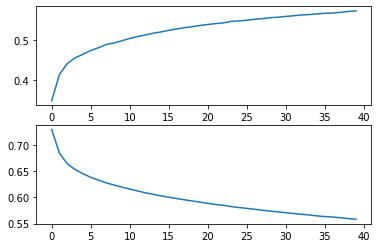

In [ ]:
x = np.linspace(0, epochs, num=epochs, endpoint=False, dtype=int)
coef = repetitions * n_actual
corrects /= coef
costs /= coef

pyplot.subplot(2, 1, 1)
pyplot.plot(x, corrects, title='Accuracy')

pyplot.subplot(2, 1, 2)
pyplot.plot(x, costs, title='Loss')

# Accuracy of the unvectorised model:
The unvectorised version of the model runs on average for 30s to process 800 input images of 4 classes.
The accuracy of such a model can vary between 28% to 31%.

# Accuracy of the vectorised model:
The vectorised version of the model runs on average for 3 minutes to process 20000 input images of 4 classes.
The accuracy of such a model can rise up to 55%.

# Testing the model on test images
The accuracy of the model on test data runs around 53-55%.

In [ ]:
accuracy = 0
test_cost = 0
for img, label in zip(grey_test_imgs, test_labels):
  o, z = feed_forward(img, w, b)
  if np.argmax(o[2]) == np.argmax(label):
    accuracy += 1
  test_cost += np.sum((o[2] - label) ** 2)

accuracy /= n_test_samples
test_cost /= n_test_samples

print('Validation Accuracy: {}'.format(accuracy))
print('Validation Loss: {}'.format(test_cost))

Validation Accuracy: 0.5415
Validation Loss: 1.7441909542281724
